# Most popular drug

In [5]:
import pandas as pd
from ggplot import *

# not sure if this is needed anymore
import matplotlib.pyplot as plt
%matplotlib inline

project_id = "the-d-team-164512"

query = """\
SELECT
  GROUP_CONCAT(UNIQUE(STRING(t.Drug_ID)), ',') AS drug_ids
  , FIRST(d.MasterProductFullName) AS first_drug_name
  , d.BrandName
  , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
GROUP BY
  d.BrandName
ORDER BY transaction_count DESC
LIMIT 10
"""

df = pd.read_gbq(query, project_id)
df

Waiting for job to complete...


,drug_ids,first_drug_name,d_BrandName,transaction_count
0,"2120,2119,2117,2118",CRESTOR TAB 5MG 30,CRESTOR,1827302
1,6470,PANADOL OSTEO SR-TAB 665MG 96,PANADOL OSTEO,1693547
2,"4869,4867,4860,4861",LIPITOR TAB 80MG 30,LIPITOR,1635951
3,"5884,5887,5883",NEXIUM EC-TABS 20MG 30,NEXIUM,1539498
4,"2105,2104,2106,2103",COVERSYL TAB 2MG 30,COVERSYL,1071237
5,"5372,5373",MICARDIS TAB 40MG 28,MICARDIS,830642
6,8208,SPIRIVA INH-CAP 18MCG 30,SPIRIVA,771540
7,"6031,6032",NOTEN TAB 50MG 30 BLISTER,NOTEN,753504
8,"767,765,763,764",ATACAND TAB 4MG 30,ATACAND,732852
9,"8168,8157,8156,8166,8165",SOMAC EC-TABS 20MG 30 BLISTER,SOMAC,687873


## Most popular drug by time

In [101]:
query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE t.Drug_ID IN ({0})
GROUP BY
  brand_name
  , year_month
ORDER BY
  brand_name
  , year_month ASC
"""

query = query.format(",".join(df['drug_ids']))
df_pop_by_year_month = pd.read_gbq(query, project_id)
df_pop_by_year_month.head(3)

Waiting for job to complete...


,brand_name,year_month,transaction_count
0,ATACAND,2010-12-01,25
1,ATACAND,2011-01-01,13861
2,ATACAND,2011-02-01,12254


Most popular drugs seem to show varied behaviour in spikes and changes in popularity as **Lipitor** shows below. This leads to a number of questions:

- if a drug looses popularity, what takes it's place?
- why are there seasonal or monthly changes?
- why is  there a data loss for 2016?
- is **dispense week** the correct data to use?

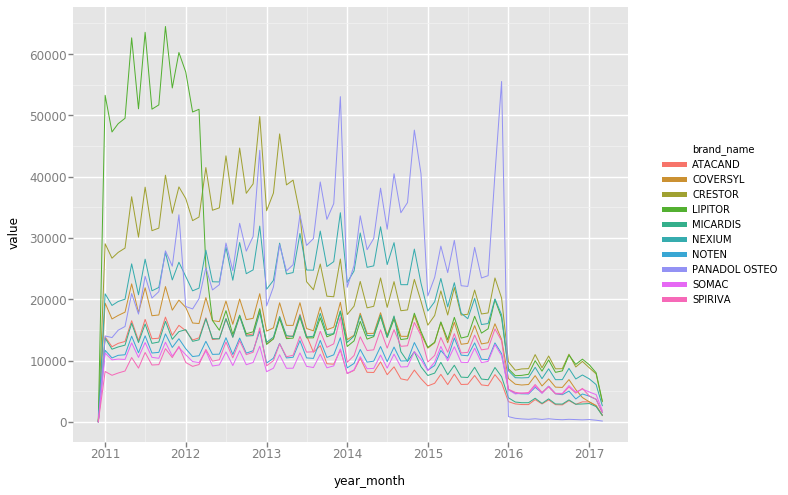

<ggplot: (288575906)>

In [109]:
df_pop_by_year_month.year_month = pd.Series(df_pop_by_year_month.year_month).apply(pd.to_datetime, format='%Y-%m')

df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month, id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()

### Atacand
[Atacand](https://www.healthdirect.gov.au/medicines/brand/amt,3659011000036102/atacand) is used for:

    Treatment of Hypertension. Treatment of patients with heart failure and impaired left ventricular systolic function (left ventricular ejection fraction less than or equal to 40%) as add-on therapy to ACE inhibitors or when ACE inhibitors are not tolerated.

Looking at the data it seems to have had slight growth 2011 - 2103 and then a clear decline

- has it been replaced by another drug?

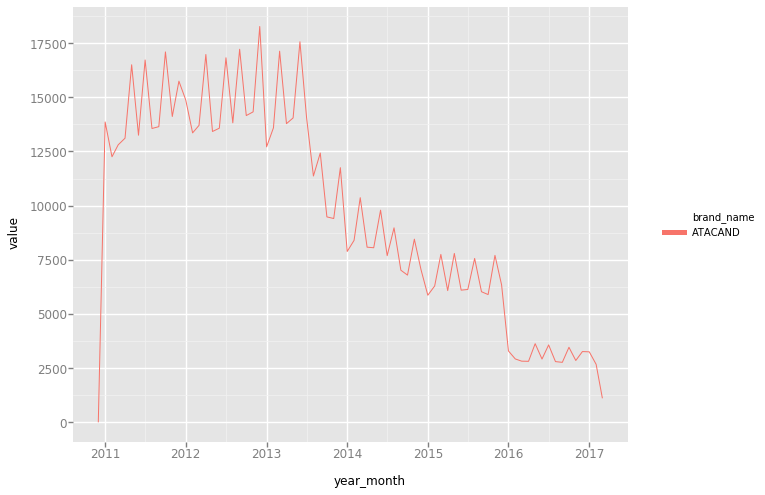

<ggplot: (288435208)>

In [112]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'ATACAND'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()

### Coversyl
[Coversyl](https://www.healthdirect.gov.au/medicines/brand/amt,2933011000036107/coversyl) is used for

    COVERSYL is indicated for: the treatment of hypertension; and the treatment of heart failure. In such patients it is recommended that COVERSYL be given with a diuretic and/or digoxin under close medical supervision. (The safety and efficacy of COVERSYL has not been demonstrated for New York Heart Association Category IV patients); and patients with established coronary artery disease (See Clinical Trials) who are stable on concomitant therapy and have no heart failure, to reduce the risk of non-fatal myocardial infarction or cardiac arrest.

This seems to have a clear steady decline but why?

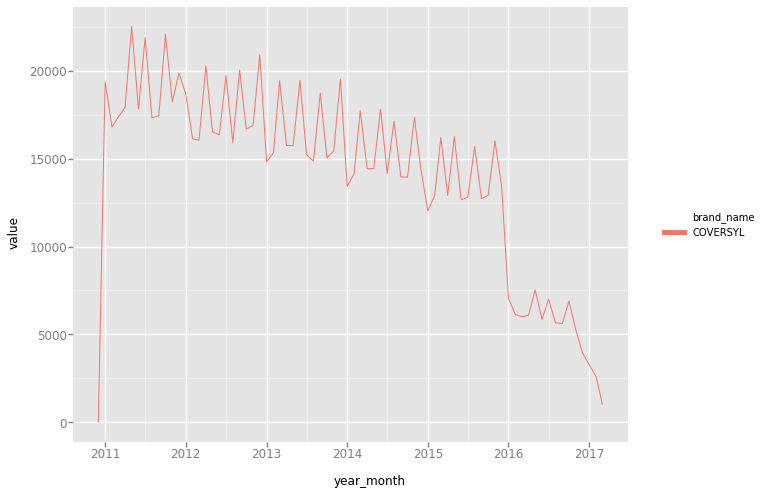

<ggplot: (287444130)>

In [113]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'COVERSYL'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()    

### CRESTOR

[Crestor](https://www.healthdirect.gov.au/medicines/brand/amt,4031011000036106/crestor) is used for

    CRESTOR should be used as an adjunct to diet when the response to diet and exercise is inadequate.,Prevention of Cardiovascular Events,CRESTOR is indicated for prevention of major cardiovascular events in men greater than or equal to 50 years old and women greater than or equal to 60 years old with no clinically evident cardiovascular disease but with at least two conventional risk factors for cardiovascular disease (hypertension, low HDL-C, smoking, or a family history of premature coronary heart disease).,CRESTOR is indicated to: = Reduce the risk of nonfatal myocardial infarction = Reduce the risk of nonfatal stroke. = Reduce the risk of coronary artery revascularisation procedures. In patients with hypercholesterolaemia: CRESTOR is indicated for the treatment of hypercholesterolaemia (including familial hypercholesterolaemia). Prior to initiating therapy with CRESTOR , secondary causes of hypercholesterolaemia (e.g. poorly controlled diabetes mellitus, hypothyroidism, nephrotic syndrome, dysproteinaemias, obstructive liver disease, other drug therapy, alcoholism) should be identified and treated.
    
Weight loss? seemed very popoular 2011-2012 but plumeted suddenly in 2013

- why did it plumet? anything in the news?

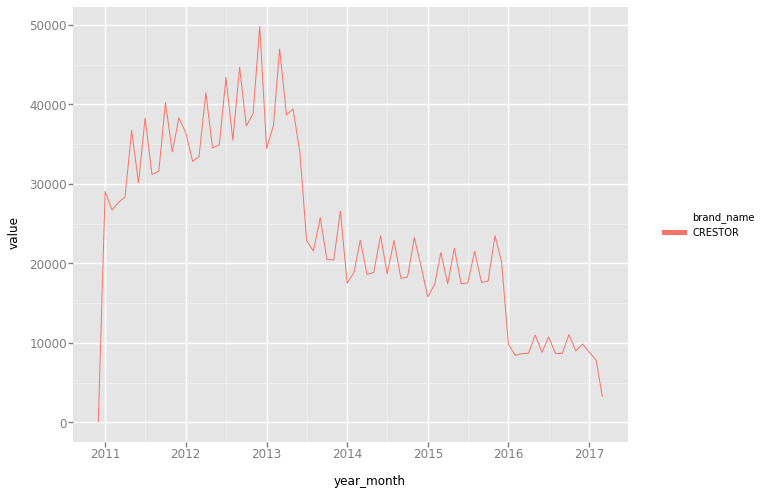

<ggplot: (289006393)>

In [114]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'CRESTOR'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()    

### Lipitor
[Lipitor](https://www.healthdirect.gov.au/medicines/brand/amt,3877011000036101/lipitor) is used for

    LIPITOR is indicated as an adjunct to diet for the treatment of patients with hypercholesterolaemia. Prior to initiating therapy with atorvastatin, secondary causes of hypercholesterolaemia (e.g. poorly controlled diabetes mellitus, hypothyroidism, nephrotic syndrome, dysproteinaemias, obstructive liver disease, other drug therapy, and alcoholism) should be identified and treated. LIPITOR is indicated in hypertensive patients with multiple risk factors for coronary heart disease (CHD) which may include diabetes, history of stroke or other cerebrovascular disease, peripheral vascular disease or existing asymptomatic CHD (see Clinical Trials, Prevention of Cardiovascular Disease) to reduce the risk of non-fatal myocardial infarction and non-fatal stroke. These effects do not replace the need to independently control known causes of cardiovascular mortality and morbidity such as hypertension, diabetes and smoking.

A pretty clear fall in early 2012? why? why stable after that?

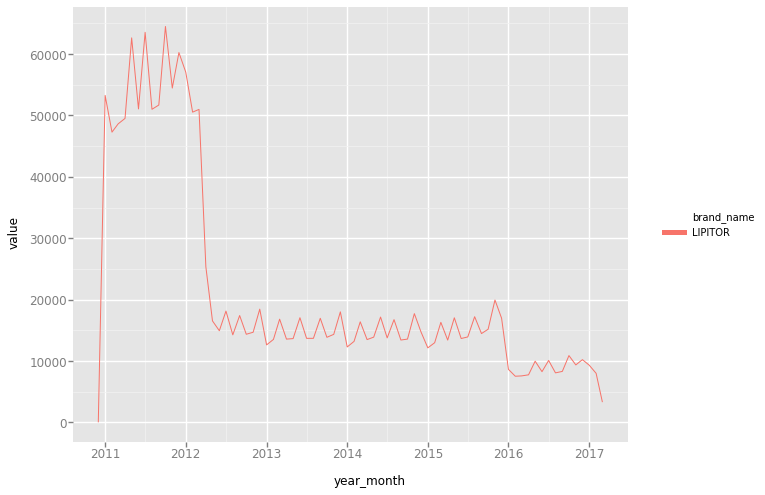

<ggplot: (-9223372036565916956)>

In [119]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'LIPITOR'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()

### Micardis

[MICARDIS]() is used for

    MICARDIS is indicated for: Treatment of hypertension. Prevention of cardiovascular morbidity and mortality in patients 55 years or older with coronary artery disease, peripheral artery disease, previous stroke, transient ischaemic attack or high risk diabetes with evidence of end organ damage (see CLINICAL TRIALS).

A gain a drop but in end of 2014, why?

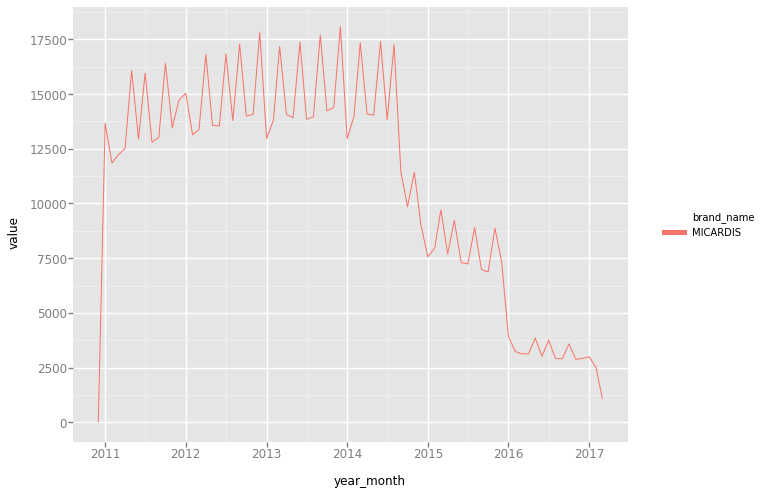

<ggplot: (289354374)>

In [116]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'MICARDIS'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()    

### Nexium

[NEXIUM]() is used for

    NEXIUM is indicated for: Gastro-Oesophageal Reflux Disease (GORD) -Treatment of erosive reflux oesophagitis -Long-term management of patients with healed oesophagitis to prevent relapse -Symptomatic treatment of gastro-oesophageal reflux disease (GORD) Patients requiring NSAID therapy: -Short-term treatment of upper gastrointestinal symptoms associated with non-steroidal anti-inflammatory drug NSAID (non-selective and COX-2 selective) therapy. -Healing of gastric ulcers associated with non-steroidal anti-inflammatory drug NSAID (non-selective and COX-2 selective) therapy. -Prevention of gastric and duodenal ulcers associated with non-steroidal anti-inflammatory drug NSAID (non-selective and COX-2 selective) therapy in patients at risk. Prevention of rebleeding of gastric or duodenal ulcers following treatment with NEXIUM IV solution by intravenous infusion. Pathological hypersecretory conditions including Zollinger-Ellison syndrome and idiopathic hypersecretion. In combination with appropriate antibiotics for: -Healing of duodenal ulcer associated with Helicobacter pylori. -Eradication of Helicobacter pylori in patients with active or healed peptic ulcer.

a rise peak and decline but very different from the others, why?

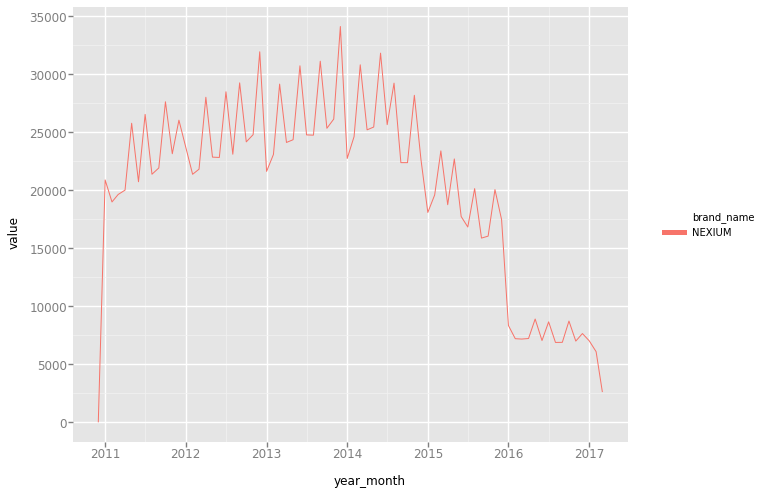

<ggplot: (-9223372036565763461)>

In [117]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'NEXIUM'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()    

### Noten
[Noten](https://www.healthdirect.gov.au/medicines/brand/amt,4422011000036109/noten) is used for

    INDICATIONS AS AT 9 APRIL 1996 : Atenolol is indicated in the management of: 1. All grades of hypertension, including hypertension of renal origin. 2. Frequently disabling angina without evidence of cardiac failure. Atenolol is also used as maintenance therapy for cardiac arrhythmias and following myocardial infarction.

Gradual decline in use but each year it peaks? why? why are there peaks every 3 months?

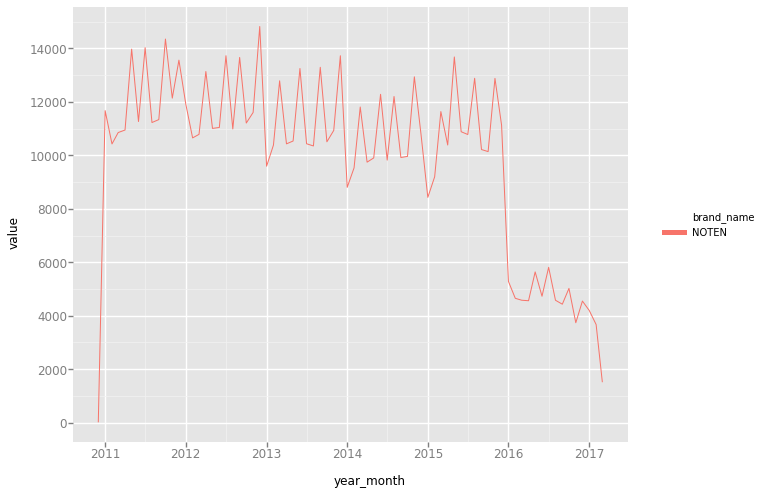

<ggplot: (289472548)>

In [118]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'NOTEN'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()    

### Pandaol Osteo
[Panadol osteo](https://www.healthdirect.gov.au/medicines/brand/amt,47941000168100/panadol-osteo) is used for

    Effective relief from persistent pain for up to 8 hours. Effective for the relief of persistent pain associated with osteoarthritis and muscular aches and pains such as backache. Provides effective temporary relief of pain and discomfort associated with: headache, tension headache, cold and flu, period pain, toothache and pain after dental procedures. Reduces fever.

pronounced peaks each year which seem to reset but overall popularity still seems to grow, why the peaks in Dec?

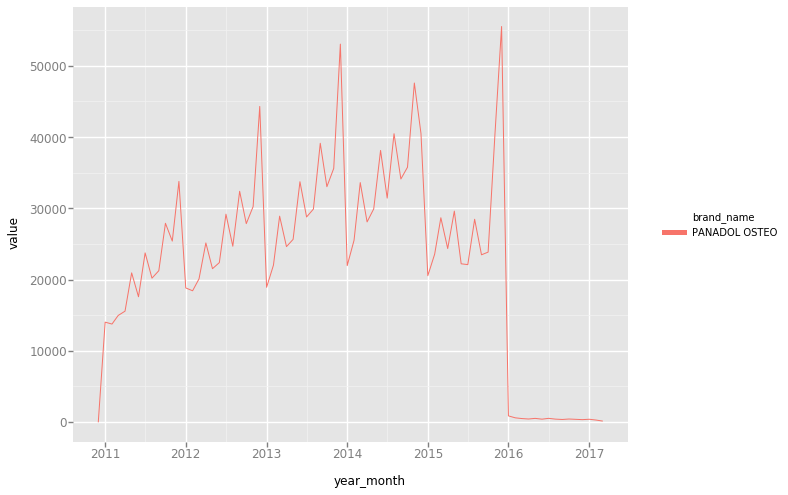

<ggplot: (289589161)>

In [120]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'PANADOL OSTEO'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()

### Somac
[Somac](https://www.healthdirect.gov.au/medicines/brand/amt,10171000168100/somac) is used for

    1. For symptomatic improvement and healing of gastrointestinal diseases which require a reduction in acid secretion:- i) duodenal ulcer, ii) gastric ulcer, iii) gastro-oesophageal reflux disease (GORD): Symptomatic GORD. The treatment of heartburn and other symptoms associated with GORD; Reflux oesophagitis iv) gastrointestinal lesions refractory H2 blockers v) Zollinger-Ellison Syndrome. Patients whose gastric or duodenal ulceration is not associated with ingestion of non-steroidal anti-inflammatory drugs (NSAIDs) require treatment with antimicrobial agents in addition to antisecretory drugs whether on first presentation or on recurrence. 2. Maintenance of healed reflux oesophagitis in patients previously treated for moderate to severe reflux oesophagitis. 3. For eradication of Helicobacter pylori, treatment with pantoprazole and one of the following combinations of antibiotics; i) Clarithromycin and amoxicillin, or ii) Clarithromycin and metronidazole, or iii) Amoxicillin and metronidazole is recommended in cases of duodenal ulcer and gastric ulcer with the objective of reducing the recurrence of duodenal and gastric ulcers caused by this microorganism (see Dosage & Administration). 4. Pantoprazole in combination with bismuth, metronidazole and tetracycline is indicated for the eradication of Helicobacter pylori associated with peptic ulcer disease with the objective of reducing the recurrence of peptic ulcers caused by this organism. 5. Prevention of gastroduodenal lesions and dyspeptic symptoms associated with non-selective non-steroidal anti-inflammatory drugs (NSAIDs) in increased risk patients with a need for continuous non-selective NSAID treatment.

a bit of a dip and started to recover?

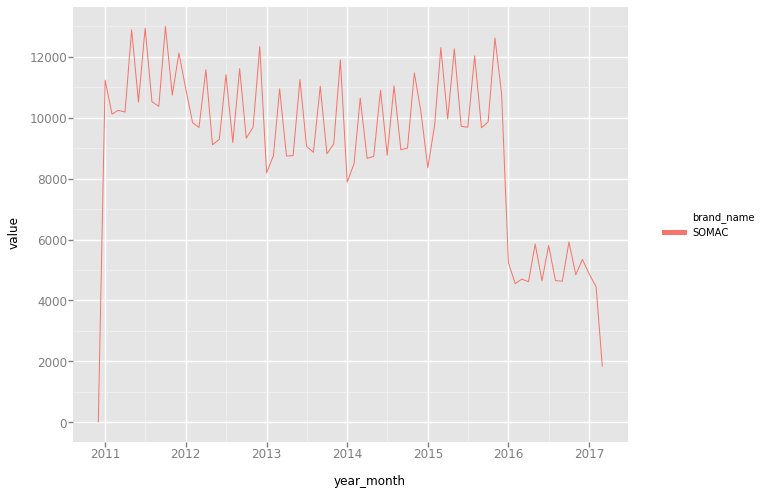

<ggplot: (289993185)>

In [121]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'SOMAC'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()

### Spiriva
[Spiriva]() is used for

    SPIRIVA is indicated for the long term maintenance treatment of bronchospasm and dyspnoea associated with chronic obstructive pulmonary disease (COPD). SPIRIVA is indicated for the prevention of COPD exacerbations.

again a growing with peak in Dec a bit like **panadol osteo** 2 above? why?

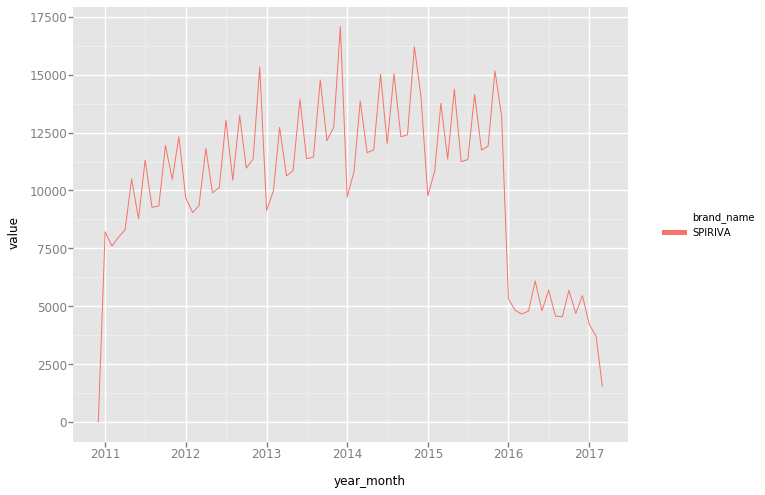

<ggplot: (-9223372036564516264)>

In [123]:
df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month[df_pop_by_year_month['brand_name'] == 'SPIRIVA'], id_vars=['year_month', 'brand_name'])
ggplot(
    aes(x='year_month', y='value', colour='brand_name'),
    data=df_pop_by_year_month_lng) +\
    geom_line()

## All transactions by time
All transactions for all medicines

In [38]:
query = """\
SELECT
  DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
GROUP BY year_month
ORDER BY year_month ASC
"""

df_tran_by_month = pd.read_gbq(query, project_id)
df_tran_by_month.head(3)

Waiting for job to complete...
Waiting for job to complete...


,year_month,transaction_count
0,2010-12-01,1391
1,2011-01-01,729367
2,2011-02-01,657118


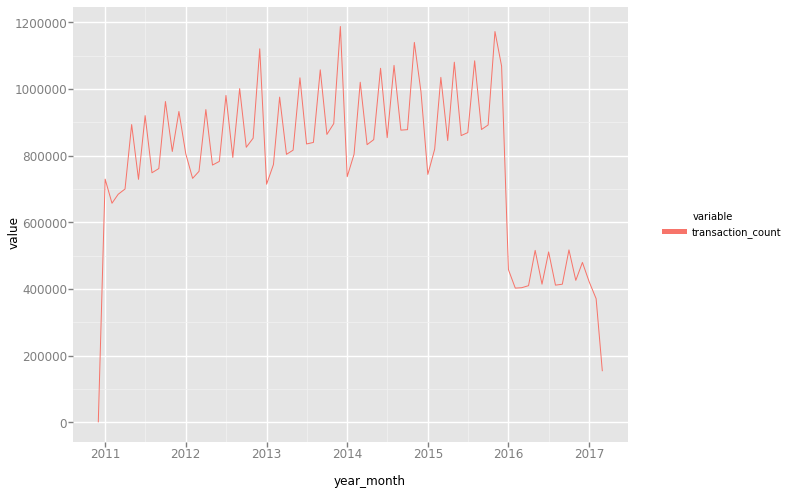

<ggplot: (-9223372036570586301)>

In [57]:
df_tran_by_month.year_month = pd.Series(df_tran_by_month.year_month).apply(pd.to_datetime, format='%Y-%m-%d')

tran_by_month_lng = pd.melt(df_tran_by_month, id_vars=['year_month'])
ggplot(
    aes(x='year_month', y='value', colour='variable'),
    data=tran_by_month_lng) +\
    geom_line()

/opt/boxen/homebrew/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


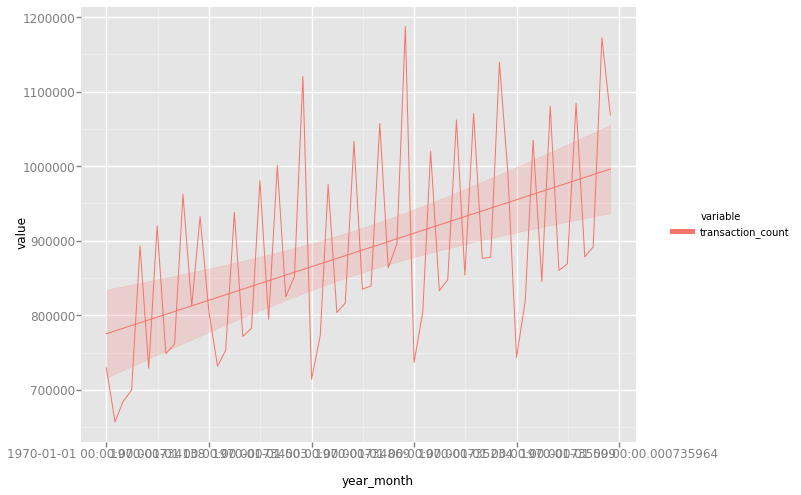

<ggplot: (286634658)>

In [61]:
tran_by_month_lng_ltd = pd.melt(df_tran_by_month['2011-01-01' : '2015-12-31'], id_vars=['year_month'])
ggplot(
    aes(x='year_month', y='value', colour='variable'),
    data=tran_by_month_lng_ltd) +\
    geom_line() +\
    stat_smooth(colour='blue', span=0.2)